# Text Classification on Clean IMDB Dataset using TPOT

## 1. Experiment Details
|Specification|Value|
|----|----|
|AutoML Algorithm|TPOT|
|Task|Text Classification|
|Dataset|IMDB Movie Reviews|
|Dataset Clean|Yes|
|Noise Type|NA|

## 2. Load Packages

In [1]:
# Packages for data processing
import numpy as np
import pandas as pd
from scripts.add_noise import add_gaussian_noise, add_random_noise
from scripts.data_preprocess import preprocess_text
from sklearn.model_selection import train_test_split

# Packages for AutoML framework execution
from tpot import TPOTClassifier
from tpot.export_utils import set_param_recursive
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Packages for evaluation plots
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from scripts.plot_model_scores import get_plot_model

random_state = 42

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yogesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yogesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 3. Load and Pre-process Dataset

In [2]:
# Get the required dataset from the datasets folder
imdb_df = pd.read_csv("../datasets/clean/imdb.csv", index_col=0)

In [3]:
# Sample the data for experimentation purposes
# Some AutoML frameworks can take long time to test multiple pipelines on large-scale data (e.g. 4+ hours on 50K+ text data)
imdb_df = imdb_df.sample(frac=0.2, replace=False, random_state=random_state)

In [4]:
# Certain AutoML frameworks such as TPOT require the target variable to be explicitly named as 'target'
imdb_df.reset_index(inplace=True)
imdb_df.rename(columns={'sentiment':'target'}, inplace=True)
imdb_df['target'] = imdb_df['target'].apply(lambda x: 1 if x =='positive' else 0)

In [5]:
# Pre-process the text to lower case, remove stopwords, lemmatize, etc.
imdb_df['tokenized_review'] = imdb_df['review'].apply(preprocess_text)

In [6]:
# Create a Word2Vec model and obtain embeddings for all the reviews in the dataset
from gensim.models import Word2Vec

sentences = imdb_df['tokenized_review'].tolist()
w2v_model_path = "word2vec_imdb"
w2v_model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, sg=0)
w2v_model.save(f"{w2v_model_path}.model")

In [7]:
if w2v_model is None: w2v_model = Word2Vec.load(f'{w2v_model_path}.model')

def get_w2v_average_embedding(tokens):
  # Calculate average word embedding for the tokens in a row
  vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
  if vectors: 
    return sum(vectors) / len(vectors)
  else:
    return None
  
imdb_df['review_embeddings'] = imdb_df['tokenized_review'].apply(get_w2v_average_embedding)

In [8]:
imdb_df.head()

,review,target,tokenized_review,review_embeddings
0,I really liked this Summerslam due to the look...,1,"[really, liked, summerslam, due, look, arena, ...","[0.080072105, 0.13578771, 0.29884213, 0.234385..."
1,Not many television shows appeal to quite as m...,1,"[many, television, show, appeal, quite, many, ...","[0.15968667, 0.31144753, 0.3896122, 0.48439282..."
2,The film quickly gets to a major chase scene w...,0,"[film, quickly, get, major, chase, scene, ever...","[-0.022964837, 0.41573265, 0.3376071, 0.546959..."
3,Jane Austen would definitely approve of this o...,1,"[jane, austen, would, definitely, approve, one...","[0.1735865, 0.3592627, 0.51284564, 0.43608963,..."
4,Expectations were somewhat high for me when I ...,0,"[expectation, somewhat, high, went, see, movie...","[0.086667106, 0.31352386, 0.36334798, 0.515368..."


## 4. Find Best Model using AutoML

In [9]:
# Split the dataset into traning and testing splits
X_train, X_test, y_train, y_test = train_test_split(np.vstack(imdb_df['review_embeddings']),
                                                    imdb_df.loc[:, 'target'], 
                                                    train_size=0.75, test_size=0.25, random_state=random_state)

In [10]:
# Run the TPOT framework to run its optimization (note: this may take a long time depending on the dataset)
# The current configuration takes about 15-30 minutes to complete
tpot = TPOTClassifier(generations=2, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/150 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8057333333333332

Generation 2 - Current best internal CV score: 0.8057333333333332

Best pipeline: LogisticRegression(input_matrix, C=25.0, dual=False, penalty=l2)


TPOTClassifier(generations=2, population_size=50, random_state=42, verbosity=2)

In [11]:
# Export the pipeline configuration for direct future use
tpot.export('textclf_cleandata_tpot_bestmodelpipeline.py')

## 5. Train Model and Predict

In [18]:
# Now, we fit the model as suggested by the TPOT framework to the dataset and make predictions
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

automl_model = make_pipeline(
    Normalizer(norm="l2"),
    LinearSVC(C=15.0, dual=False, loss="squared_hinge", penalty="l2", tol=0.1)
    # LogisticRegression(C=25.0, dual=False, penalty="l2")
)

# Fix TPOT random state for all the steps in exported pipeline
set_param_recursive(automl_model.steps, 'random_state', random_state)

automl_model.fit(X_train, y_train)
y_pred_automl = automl_model.predict(X_test)

## 6. Evaluate Model

In [14]:
# We now evaluate our model performances on this dataset and compare against the Naive Bayes benchmark
precision_automl = precision_score(y_true=y_test, y_pred=y_pred_automl)
recall_automl = recall_score(y_true=y_test, y_pred=y_pred_automl)
f1_automl = f1_score(y_true=y_test, y_pred=y_pred_automl)

model_names = ['AutoML-TPOT']
plot_title = 'Clean Data - TPOT Performance'
f1_scores = [f1_automl]
recall_scores = [recall_automl]
precision_scores = [precision_automl]

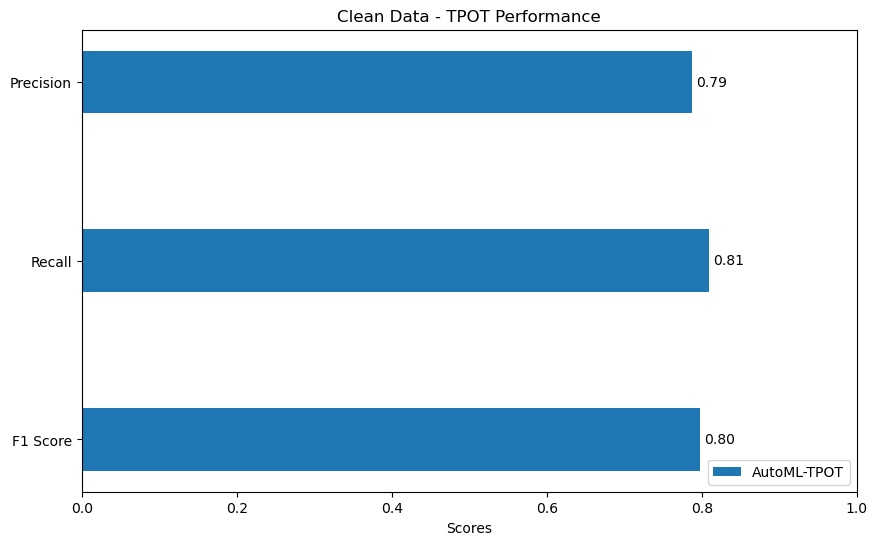

In [15]:
fig = get_plot_model(model_names=model_names, f1_scores=f1_scores, recall_scores=recall_scores, precision_scores=precision_scores, title=plot_title)
plt.show()